<a href="https://colab.research.google.com/github/bzhanglab/AutoRT/blob/master/example/Experiment_specific_RT_prediction_using_AutoRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AIC lab Experiment RT prediction using AutoRT


Importing all libs

In [1]:
import tensorflow as tf
import torch
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

set_matplotlib_formats('svg')


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

2024-05-10 17:08:03.574382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 17:08:03.574512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 17:08:03.704764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cuda:0


/tmp/ipykernel_25/2637101405.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


### Installation

#### Run AutoRT on local computer

Only run the following code when run this notebook on local computer. Make sure all the dependent libraries and packages are installed successfully. 

In [2]:
## install cuda library for tensorflow 2.6
# ! conda install cudatoolkit=11.2
# ! conda install -c fastchan cudnn=8.1.0.77

## install AutoRT
! git clone https://github.com/bzhanglab/AutoRT
! ls -l -t
! pip install -r AutoRT/requirements.txt

Cloning into 'AutoRT'...
remote: Enumerating objects: 590, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 590 (delta 97), reused 46 (delta 20), pack-reused 428
Receiving objects: 100% (590/590), 1.33 GiB | 38.57 MiB/s, done.
Resolving deltas: 100% (285/285), done.
Updating files: 100% (94/94), done.
total 92
drwxr-xr-x 6 root root  4096 May 10 17:09 AutoRT
---------- 1 root root 86314 May 10 17:08 __notebook__.ipynb
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


### Example dataset

In this example, we will use a dataset tide-index.peptides.txt

In [3]:
## go to the folder example
%cd AutoRT/example/

/kaggle/working/AutoRT/example


In [4]:
! ls -l

total 1640
-rw-r--r-- 1 root root 349855 May 10 17:09 Experiment_specific_RT_prediction_using_AutoRT.ipynb
-rw-r--r-- 1 root root 578256 May 10 17:09 Experiment_specific_RT_prediction_using_AutoRT_MaxQuant_Ecoli.ipynb
-rw-r--r-- 1 root root 532275 May 10 17:09 Phosphorylation_experiment_specific_RT_prediction_using_AutoRT_Colab.ipynb
-rw-r--r-- 1 root root      1 May 10 17:09 README.md
-rw-r--r-- 1 root root 189557 May 10 17:09 RT_prediction_using_AutoRT.ipynb
drwxr-xr-x 4 root root   4096 May 10 17:09 data
drwxr-xr-x 2 root root   4096 May 10 17:09 scripts
-rw-r--r-- 1 root root    373 May 10 17:09 train_model_from_scratch.sh
-rw-r--r-- 1 root root    359 May 10 17:09 transfer_learning.sh


Make sure you are using the right path to the dataset. Our experiments were on kaggle

In [5]:
peptides_df = pd.read_csv("/kaggle/input/aic-dataset/tide-index.peptides.txt",sep="\t")

print("The number of rows: %d" % (peptides_df.shape[0]))
peptides_df.head()

The number of rows: 38947028


,target,decoy(s),mass,proteins
0,GGGAGLG,GLGAGGG,487.2390,tr|A0A087WX29|A0A087WX29_HUMAN(237)
1,GGGGGGK,NaN,488.2343,sp|Q9H461|FZD8_HUMAN(211)
2,GGGGGAK,GAGGGGK,502.2499,"tr|K7EQ17|K7EQ17_HUMAN(56),sp|O94818|NOL4_HUMA..."
3,AGGGGGK,NaN,502.2499,sp|P20648|ATP4A_HUMAN(32)
4,GGAGAGQ,GGAGGAQ,516.2292,tr|A0A0D9SES6|A0A0D9SES6_HUMAN(138)


In [6]:
peptides_df.tail()

,target,decoy(s),mass,proteins
38947023,YQRSHDDT[79.9663]TPWERLWFLLLTFTFGLTLTWLY[79.96...,YNYLYWNFEDYDNHVEWWFY[79.9663]LWTLTLGFTFTLLLFWL...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."
38947024,YQRSHDDT[79.9663]TPWERLWFLLLTFTFGLTLT[79.9663]...,YNYLYWNFEDYDNHVEWWFYLWT[79.9663]LTLGFTFTLLLFWL...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."
38947025,YQRSHDDT[79.9663]TPWERLWFLLLTFTFGLT[79.9663]LT...,YNYLYWNFEDYDNHVEWWFYLWTLT[79.9663]LGFTFTLLLFWL...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."
38947026,YQRSHDDT[79.9663]TPWERLWFLLLTFT[79.9663]FGLTLT...,YNYLYWNFEDYDNHVEWWFYLWTLTLGFT[79.9663]FTLLLFWL...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."
38947027,YQRSHDDT[79.9663]TPWERLWFLLLT[79.9663]FTFGLTLT...,YNYLYWNFEDYDNHVEWWFYLWTLTLGFTFT[79.9663]LLLFWL...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."


In [7]:
peptides_df[20000:20020]

,target,decoy(s),mass,proteins
20000,GSACSNR,GNSCASR,750.3079,"sp|Q5SNT2|TM201_HUMAN(597),tr|H0Y4R5|H0Y4R5_HU..."
20001,WGGSGCK,WCGSGGK,750.3119,"sp|Q8TF72|SHRM3_HUMAN(1299),tr|A0A2R8Y5P9|A0A2..."
20002,STDGESR,SSEGDTR,750.3144,sp|Q8TAA9|VANG1_HUMAN(257)
20003,SEGESSR,SSSEGER,750.3144,tr|A0A3B3IRZ4|A0A3B3IRZ4_HUMAN(92)
20004,DSSNNSK,DSNNSSK,750.3144,sp|Q9NZW4|DSPP_HUMAN(272)
20005,AM[15.9949]GGM[15.9949]PR,APM[15.9949]GGM[15.9949]R,750.3152,sp|Q8NBC4|CT203_HUMAN(135)
20006,MGQAGCK,MCGAQGK,750.3153,"sp|Q93086|P2RX5_HUMAN(1),tr|K7EQ78|K7EQ78_HUMA..."
20007,GVCGACK,GCAGCVK,750.3153,"tr|F5GZ78|F5GZ78_HUMAN(354),sp|P49023|PAXI_HUM..."
20008,MGNGMNK,MNMGNGK,750.3153,"sp|Q9NRW4|DUS22_HUMAN(1),tr|S4R459|S4R459_HUMA..."
20009,VKDM[15.9949]AGD,VGAM[15.9949]DKD,750.3218,tr|H3BP14|H3BP14_HUMAN(136)


### Modifications

For a peptide with modification(s) (modified peptide), it must be formatted as described below:

Each of the modified amino acids must be represented using a different integer number (0-9) in the peptide sequence and keep consistent in both training and testing (or prediction) data. For example, if there are four modifications in a dataset: oxidation on M, phosphorylation on S,T and Y, then we can use 1 represents oxidation of M, 2 represents phosphorylation of S, 3 represents phosphorylation of T and 4 represents phosphorylation of Y.

Here is a modified version of the format_modified_peptide function that can be used to replace the specified substrings in the 'target' and 'decoy(s)' columns of a DataFrame:


In [8]:
def replace_substring(s):
    s = str(s)
    s = s.replace('Y[79.9663]', '4')
    s = s.replace('T[79.9663]', '3')
    s = s.replace('S[79.9663]', '2')
    s = s.replace('M[15.9949]', '1')
    return s

# Apply the function to the dataframe
peptides_df['target'] = peptides_df['target'].apply(replace_substring)
peptides_df['decoy(s)'] = peptides_df['decoy(s)'].apply(replace_substring)

peptides_df[20000:20020]

,target,decoy(s),mass,proteins
20000,GSACSNR,GNSCASR,750.3079,"sp|Q5SNT2|TM201_HUMAN(597),tr|H0Y4R5|H0Y4R5_HU..."
20001,WGGSGCK,WCGSGGK,750.3119,"sp|Q8TF72|SHRM3_HUMAN(1299),tr|A0A2R8Y5P9|A0A2..."
20002,STDGESR,SSEGDTR,750.3144,sp|Q8TAA9|VANG1_HUMAN(257)
20003,SEGESSR,SSSEGER,750.3144,tr|A0A3B3IRZ4|A0A3B3IRZ4_HUMAN(92)
20004,DSSNNSK,DSNNSSK,750.3144,sp|Q9NZW4|DSPP_HUMAN(272)
20005,A1GG1PR,AP1GG1R,750.3152,sp|Q8NBC4|CT203_HUMAN(135)
20006,MGQAGCK,MCGAQGK,750.3153,"sp|Q93086|P2RX5_HUMAN(1),tr|K7EQ78|K7EQ78_HUMA..."
20007,GVCGACK,GCAGCVK,750.3153,"tr|F5GZ78|F5GZ78_HUMAN(354),sp|P49023|PAXI_HUM..."
20008,MGNGMNK,MNMGNGK,750.3153,"sp|Q9NRW4|DUS22_HUMAN(1),tr|S4R459|S4R459_HUMA..."
20009,VKD1AGD,VGA1DKD,750.3218,tr|H3BP14|H3BP14_HUMAN(136)


In [9]:
peptides_df.tail()

,target,decoy(s),mass,proteins
38947023,YQRSHDD3TPWERLWFLLLTFTFGLTLTWL4FWWEVHNDYDEFNWY...,YNYLYWNFEDYDNHVEWWF4LWTLTLGFTFTLLLFWLREWPT3DDH...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."
38947024,YQRSHDD3TPWERLWFLLLTFTFGLTL3WLYFWWEVHNDYDEFNWY...,YNYLYWNFEDYDNHVEWWFYLW3LTLGFTFTLLLFWLREWPT3DDH...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."
38947025,YQRSHDD3TPWERLWFLLLTFTFGL3LTWLYFWWEVHNDYDEFNWY...,YNYLYWNFEDYDNHVEWWFYLWTL3LGFTFTLLLFWLREWPT3DDH...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."
38947026,YQRSHDD3TPWERLWFLLLTF3FGLTLTWLYFWWEVHNDYDEFNWY...,YNYLYWNFEDYDNHVEWWFYLWTLTLGF3FTLLLFWLREWPT3DDH...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."
38947027,YQRSHDD3TPWERLWFLLL3FTFGLTLTWLYFWWEVHNDYDEFNWY...,YNYLYWNFEDYDNHVEWWFYLWTLTLGFTF3LLLFWLREWPT3DDH...,6756.0551,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."


As you can see we have peptides that are relevant to AutoRT.

### Training

Let`s train on other dataset, to predict our RT

#### Base model:
The trained base model used here is available at **AutoRT/models/base_models_PXD006109/**. The base model was trained using a large dataset which contains more than 100,000 peptides.The training data for the base model training only contains a fixed modification of Carbamidomethyl (C) and a variable modifications of Oxidation (M).We encoded modified M (Oxidation) using "1".

#### Experiment-specific RT model training:
Below is the command line for training using transfer learning strategy.


-i INPUT, --input INPUT
                        Input data for training
                        
We take .tsv file 


link to AutoRT github to understand all flags: https://github.com/bzhanglab/AutoRT/tree/master

In [10]:
! python3 ../autort.py train -i data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_train.tsv -o tf_model/ -e 40 -b 64 -u m -m ../models/general_base_model/model.json -rlr -n 10

2024-05-10 17:13:49.821863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 17:13:49.821938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 17:13:49.823450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Scaling method: min_max
Step 1:

Load aa coding data from file ../models/general_base_model/aa.tsv
AA types: 25
Longest peptide in training data: 41

Use test file tf_model//step1/validation.tsv
Longest peptide in test data: 30

['1', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
RT range: 0 - 98

X_train shap

After the training is done, the trained model is in the folder **tf_model/** (-o):

In [11]:
! ls -l tf_model/

total 196348
-rw-r--r-- 1 root root      120 May 10 17:19 aa.tsv
-rw-r--r-- 1 root root      603 May 10 17:24 model.json
-rw-r--r-- 1 root root 20402248 May 10 17:15 model_0.h5
-rw-r--r-- 1 root root 18264800 May 10 17:15 model_1.h5
-rw-r--r-- 1 root root 20555848 May 10 17:15 model_2.h5
-rw-r--r-- 1 root root 20555864 May 10 17:16 model_3.h5
-rw-r--r-- 1 root root 20402264 May 10 17:16 model_4.h5
-rw-r--r-- 1 root root 20248648 May 10 17:17 model_5.h5
-rw-r--r-- 1 root root 20555864 May 10 17:17 model_6.h5
-rw-r--r-- 1 root root 20248648 May 10 17:18 model_7.h5
-rw-r--r-- 1 root root 19555176 May 10 17:18 model_8.h5
-rw-r--r-- 1 root root 19555160 May 10 17:19 model_9.h5
-rw-r--r-- 1 root root      532 May 10 17:19 model_all.json
-rw-r--r-- 1 root root   112419 May 10 17:24 models_combination_metrics.tsv
-rw-r--r-- 1 root root   153853 May 10 17:14 new_train_data.tsv
drwxr-xr-x 4 root root     4096 May 10 17:14 step1
-rw-r--r-- 1 root root    20195 May 10 17:20 test.tsv
-rw-r--r-- 1 r

### Prediction

The column **x** is required which contains the peptides. The column "y" is not required.

We have to split our dataset. Otherwise it could memory limit. If you have an error, try to increase **n_splits**. For convenience we would drop nans

In [12]:
n_splits = 10
p = np.array_split(peptides_df, n_splits)
p1 = p[3]

p1 = p1.where(p1 != 'nan', None)

count_nan_rows = p1.isna().any(axis=1).sum()

p1 = p1.dropna(how='all')
count_nan_rows = p1.isna().any(axis=1).sum()


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


We need to modify our dataframe. We will work with targets and decoy(s) separately. We construct target_df, rename target column (to predict it correctly) and make .tsv file that our model use.

In [13]:
# so we need to modify our dataframe

target_df = p1.loc[:, ['target', 'decoy(s)']].copy()
target_df.drop('decoy(s)', axis=1, inplace=True)

target_df = target_df.rename(columns={'target': 'x'})
target_df.to_csv('peptides_to_predict_RT.tsv', index=None)
target_df.head()

,x
11684109,T3DASNEEY2LWVYQCNSLVR
11684110,T3DASNEE4SLWVYQCNSLVR
11684111,T3DA2NEEYSLWVYQCNSLVR
11684112,3TDASNEEYSLWVYQCN2LVR
11684113,3TDASNEEYSLWV4QCNSLVR


We do same with the decoy(s)

In [14]:
decoy_df = p1.loc[:, ['target', 'decoy(s)']].copy()
decoy_df.drop('target', axis=1, inplace=True)


decoy_df = decoy_df.rename(columns={'decoy(s)': 'x'})
decoy_df.to_csv('decoys_to_predict_RT.tsv', index=None)
decoy_df.head()

,x
11684109,TVLSNCQYVWL2YEENSAD3R
11684110,TVLSNCQYVWLS4EENSAD3R
11684111,TVLSNCQYVWLSYEEN2AD3R
11684112,3VL2NCQYVWLSYEENSADTR
11684113,3VLSNCQ4VWLSYEENSADTR


In [15]:
decoy_df.tail()

,x
15578807,LLRDGPPKCMRIQSQGQLLSA2PAA3R
15578808,LLRDGPPKCMRIQSQGQLL2ASPAA3R
15578809,LLRDGPPKCMRIQ2QGQLLSASPAA3R
15578810,LLRDGPPKCMRIQSQGQLL2A2PAATR
15578811,LLRDGPPKCMRIQ2QGQLLSA2PAATR


In [16]:
! ls -l

total 198948
-rw-r--r-- 1 root root    349855 May 10 17:09 Experiment_specific_RT_prediction_using_AutoRT.ipynb
-rw-r--r-- 1 root root    578256 May 10 17:09 Experiment_specific_RT_prediction_using_AutoRT_MaxQuant_Ecoli.ipynb
-rw-r--r-- 1 root root    532275 May 10 17:09 Phosphorylation_experiment_specific_RT_prediction_using_AutoRT_Colab.ipynb
-rw-r--r-- 1 root root         1 May 10 17:09 README.md
-rw-r--r-- 1 root root    189557 May 10 17:09 RT_prediction_using_AutoRT.ipynb
drwxr-xr-x 4 root root      4096 May 10 17:09 data
-rw-r--r-- 1 root root 101019028 May 10 17:25 decoys_to_predict_RT.tsv
-rw-r--r-- 1 root root 101019028 May 10 17:24 peptides_to_predict_RT.tsv
drwxr-xr-x 2 root root      4096 May 10 17:09 scripts
drwxr-xr-x 4 root root      4096 May 10 17:24 tf_model
-rw-r--r-- 1 root root       373 May 10 17:09 train_model_from_scratch.sh
-rw-r--r-- 1 root root       359 May 10 17:09 transfer_learning.sh


In [17]:
! ls -l tf_model

total 196348
-rw-r--r-- 1 root root      120 May 10 17:19 aa.tsv
-rw-r--r-- 1 root root      603 May 10 17:24 model.json
-rw-r--r-- 1 root root 20402248 May 10 17:15 model_0.h5
-rw-r--r-- 1 root root 18264800 May 10 17:15 model_1.h5
-rw-r--r-- 1 root root 20555848 May 10 17:15 model_2.h5
-rw-r--r-- 1 root root 20555864 May 10 17:16 model_3.h5
-rw-r--r-- 1 root root 20402264 May 10 17:16 model_4.h5
-rw-r--r-- 1 root root 20248648 May 10 17:17 model_5.h5
-rw-r--r-- 1 root root 20555864 May 10 17:17 model_6.h5
-rw-r--r-- 1 root root 20248648 May 10 17:18 model_7.h5
-rw-r--r-- 1 root root 19555176 May 10 17:18 model_8.h5
-rw-r--r-- 1 root root 19555160 May 10 17:19 model_9.h5
-rw-r--r-- 1 root root      532 May 10 17:19 model_all.json
-rw-r--r-- 1 root root   112419 May 10 17:24 models_combination_metrics.tsv
-rw-r--r-- 1 root root   153853 May 10 17:14 new_train_data.tsv
drwxr-xr-x 4 root root     4096 May 10 17:14 step1
-rw-r--r-- 1 root root    20195 May 10 17:20 test.tsv
-rw-r--r-- 1 r

Command to predict target`s RT

In [18]:
! python3 ../autort.py predict -t peptides_to_predict_RT.tsv -s tf_model/model.json -o tf_prediction_target/ -p test

2024-05-10 17:25:09.390433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 17:25:09.390508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 17:25:09.392116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Average ...
Load aa coding data from file tf_model/aa.tsv
AA types: 25
Longest peptide in input data: 42

['1', '2', '3', '4', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

Deep learning model: 0
1902/1902 [==============================] - 37s 19ms/step

Deep learning model: 1
1902/1902 [===============

The prediction result is in the file **tf_prediction/test.tsv**. The values in the column **y_pred** are predicted RT. Other files in the same folder are intermediate files which are not useful to users. 

In [19]:
! ls -l tf_prediction_target/

total 195588
-rw-r--r-- 1 root root 137956529 May 10 18:52 test.tsv
-rw-r--r-- 1 root root  15578940 May 10 17:27 test_0.npy
-rw-r--r-- 1 root root  15578940 May 10 17:28 test_1.npy
-rw-r--r-- 1 root root  15578940 May 10 17:29 test_2.npy
-rw-r--r-- 1 root root  15578940 May 10 17:30 test_6.npy


RT distribution in the testing data is shown below. The unit of the RT in the data is minute.

In [20]:
! ls

Experiment_specific_RT_prediction_using_AutoRT.ipynb
Experiment_specific_RT_prediction_using_AutoRT_MaxQuant_Ecoli.ipynb
Phosphorylation_experiment_specific_RT_prediction_using_AutoRT_Colab.ipynb
README.md
RT_prediction_using_AutoRT.ipynb
data
decoys_to_predict_RT.tsv
peptides_to_predict_RT.tsv
scripts
tf_model
tf_prediction_target
train_model_from_scratch.sh
transfer_learning.sh


Convert results from .tsv to python dataframe

In [21]:
pred_target_data = pd.read_csv("tf_prediction_target/test.tsv",sep="\t")
pred_target_data = pred_target_data.rename(columns={'y_pred': 'y'})

pred_target_data.head()

,x,y
0,T3DASNEEY2LWVYQCNSLVR,61.130386
1,T3DASNEE4SLWVYQCNSLVR,54.635242
2,T3DA2NEEYSLWVYQCNSLVR,58.787857
3,3TDASNEEYSLWVYQCN2LVR,58.890068
4,3TDASNEEYSLWV4QCNSLVR,55.725273


Command to predict decoy`s RT. Predictions will be in a folder **tf_prediction_decoys**

In [22]:
! python ../autort.py predict -t decoys_to_predict_RT.tsv -s tf_model/model.json -o tf_prediction_decoys/ -p test

2024-05-10 18:53:01.383711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 18:53:01.383778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 18:53:01.385375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Average ...
Load aa coding data from file tf_model/aa.tsv
AA types: 25
Longest peptide in input data: 42

['1', '2', '3', '4', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

Deep learning model: 0
1902/1902 [==============================] - 37s 19ms/step

Deep learning model: 1
1902/1902 [===============

In [23]:
! ls -l tf_prediction_decoys/

total 195600
-rw-r--r-- 1 root root 137961504 May 10 20:21 test.tsv
-rw-r--r-- 1 root root  15578940 May 10 18:55 test_0.npy
-rw-r--r-- 1 root root  15578940 May 10 18:56 test_1.npy
-rw-r--r-- 1 root root  15578940 May 10 18:57 test_2.npy
-rw-r--r-- 1 root root  15578940 May 10 18:58 test_6.npy


Convert results from .tsv to python dataframe

In [24]:
pred_decoy_data = pd.read_csv("tf_prediction_decoys/test.tsv",sep="\t")
pred_decoy_data = pred_decoy_data.rename(columns={'y_pred': 'y'})
pred_decoy_data.head()

,x,y
0,TVLSNCQYVWL2YEENSAD3R,57.378933
1,TVLSNCQYVWLS4EENSAD3R,51.714950
2,TVLSNCQYVWLSYEEN2AD3R,55.684740
3,3VL2NCQYVWLSYEENSADTR,55.642506
4,3VLSNCQ4VWLSYEENSADTR,51.245926


In [25]:
r2 = r2_score(pred_target_data['y'], pred_decoy_data['y'])

print(f"R2 score: {r2}")

R2 score: 0.9601436823864975


In [26]:
diff = abs(pred_target_data['y'] - pred_decoy_data['y'])
print(f"Max difference between target and decoy: {max(diff)};\n Min diff: {min(diff)}")

Max difference between target and decoy: 36.229825;
 Min diff: 0.0


### Drawing distributions of targets and decoys

In [27]:
# plt.rcParams.update({'font.size': 16})
# sns.set_style('whitegrid')
# np.random.seed(0xFA1AFE1)
%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

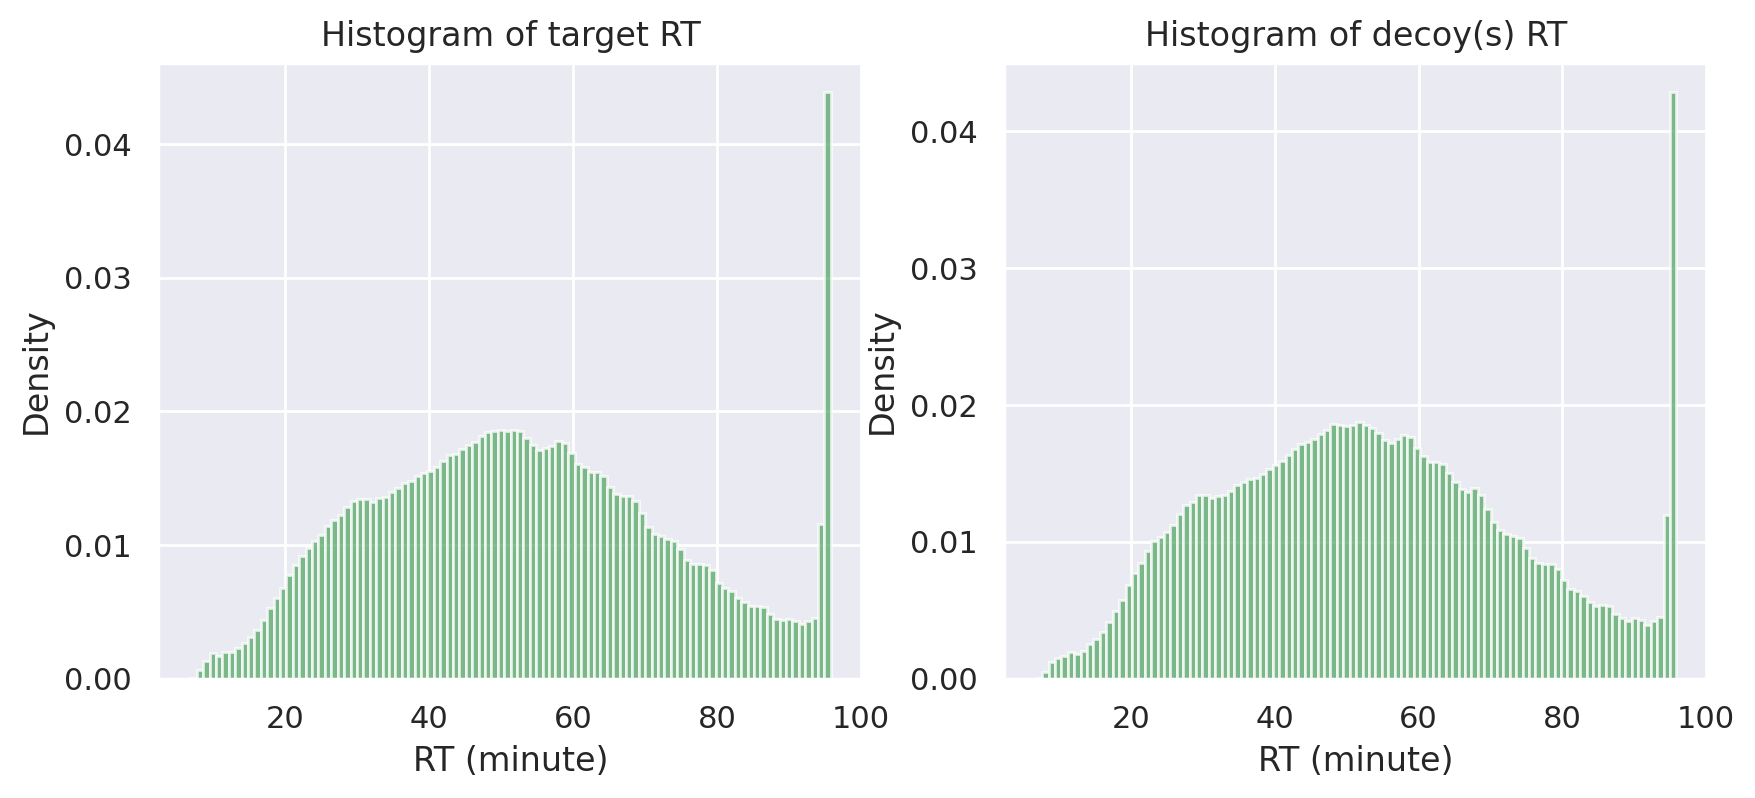

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(pred_target_data['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[0].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of target RT')
axes[1].hist(pred_decoy_data['y'], 100, density=True, facecolor='g', alpha=0.75)

# axes[1].xlabel('RT (minute)')
# axes[1].ylabel('Density')
# axes[1].title('Histogram of decoy(s) RT')

axes[1].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of decoy(s) RT')
plt.grid(True)
plt.show()

**Let`s look at plots closer**

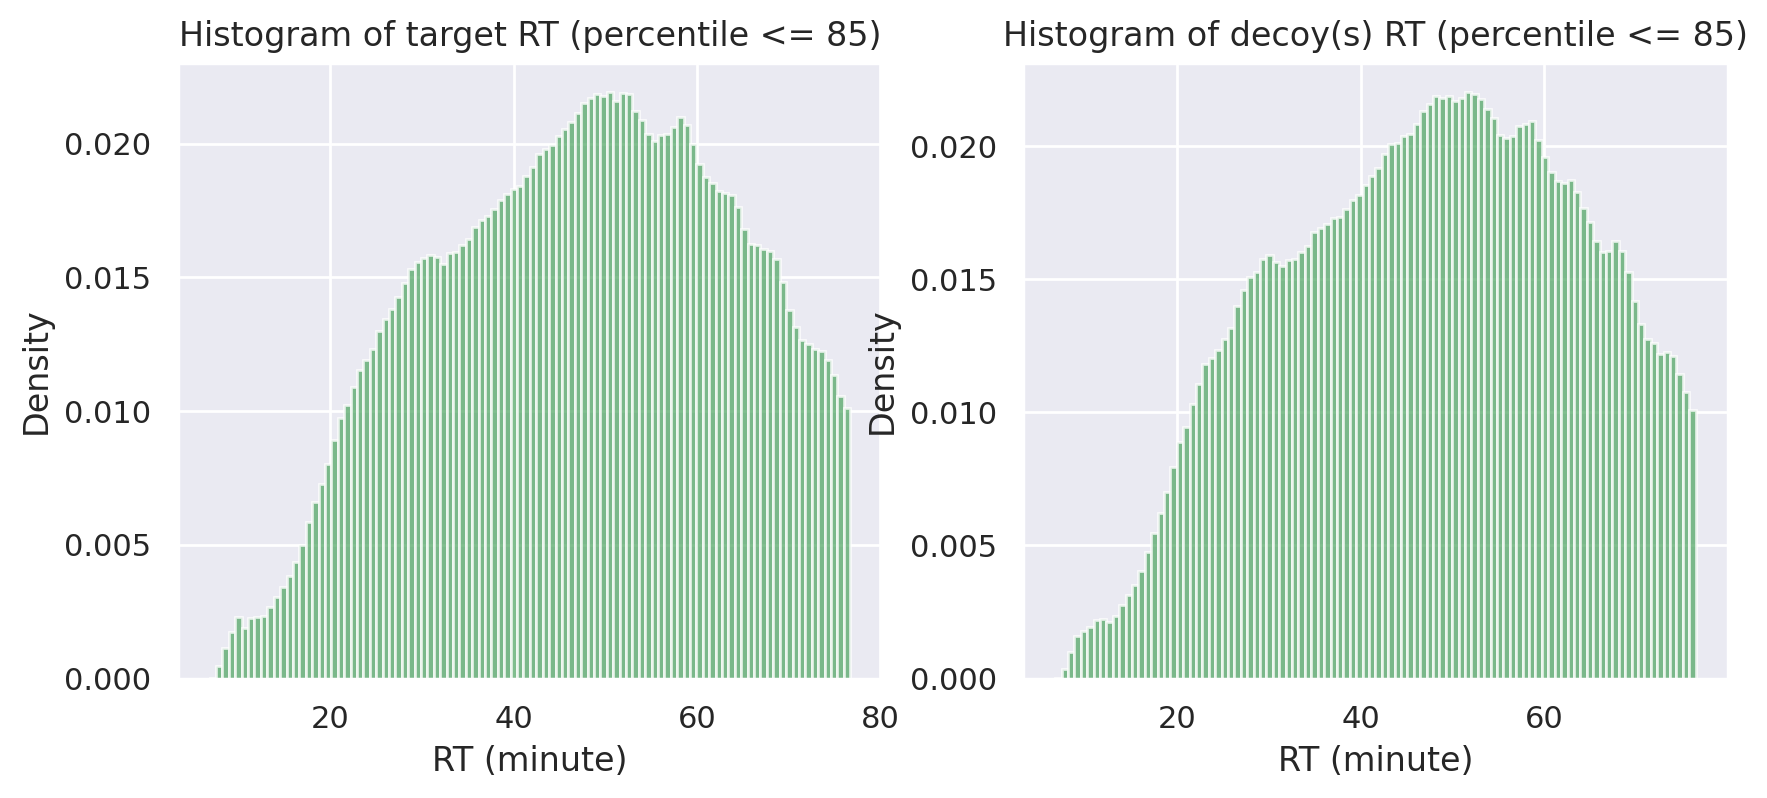

In [29]:
boolean_value1 = pred_target_data['y'].to_numpy() <= np.percentile(pred_target_data['y'].to_numpy(), 85)
boolean_value2 = pred_decoy_data['y'].to_numpy() <= np.percentile(pred_decoy_data['y'].to_numpy(), 85)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(pred_target_data[boolean_value1]['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[0].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of target RT (percentile <= 85)')
axes[1].hist(pred_decoy_data[boolean_value2]['y'], 100, density=True, facecolor='g', alpha=0.75)

# axes[1].xlabel('RT (minute)')
# axes[1].ylabel('Density')
# axes[1].title('Histogram of decoy(s) RT')

axes[1].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of decoy(s) RT (percentile <= 85)')
plt.grid(True)
plt.show()

**Code for boxplots**

/tmp/ipykernel_25/2047605321.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


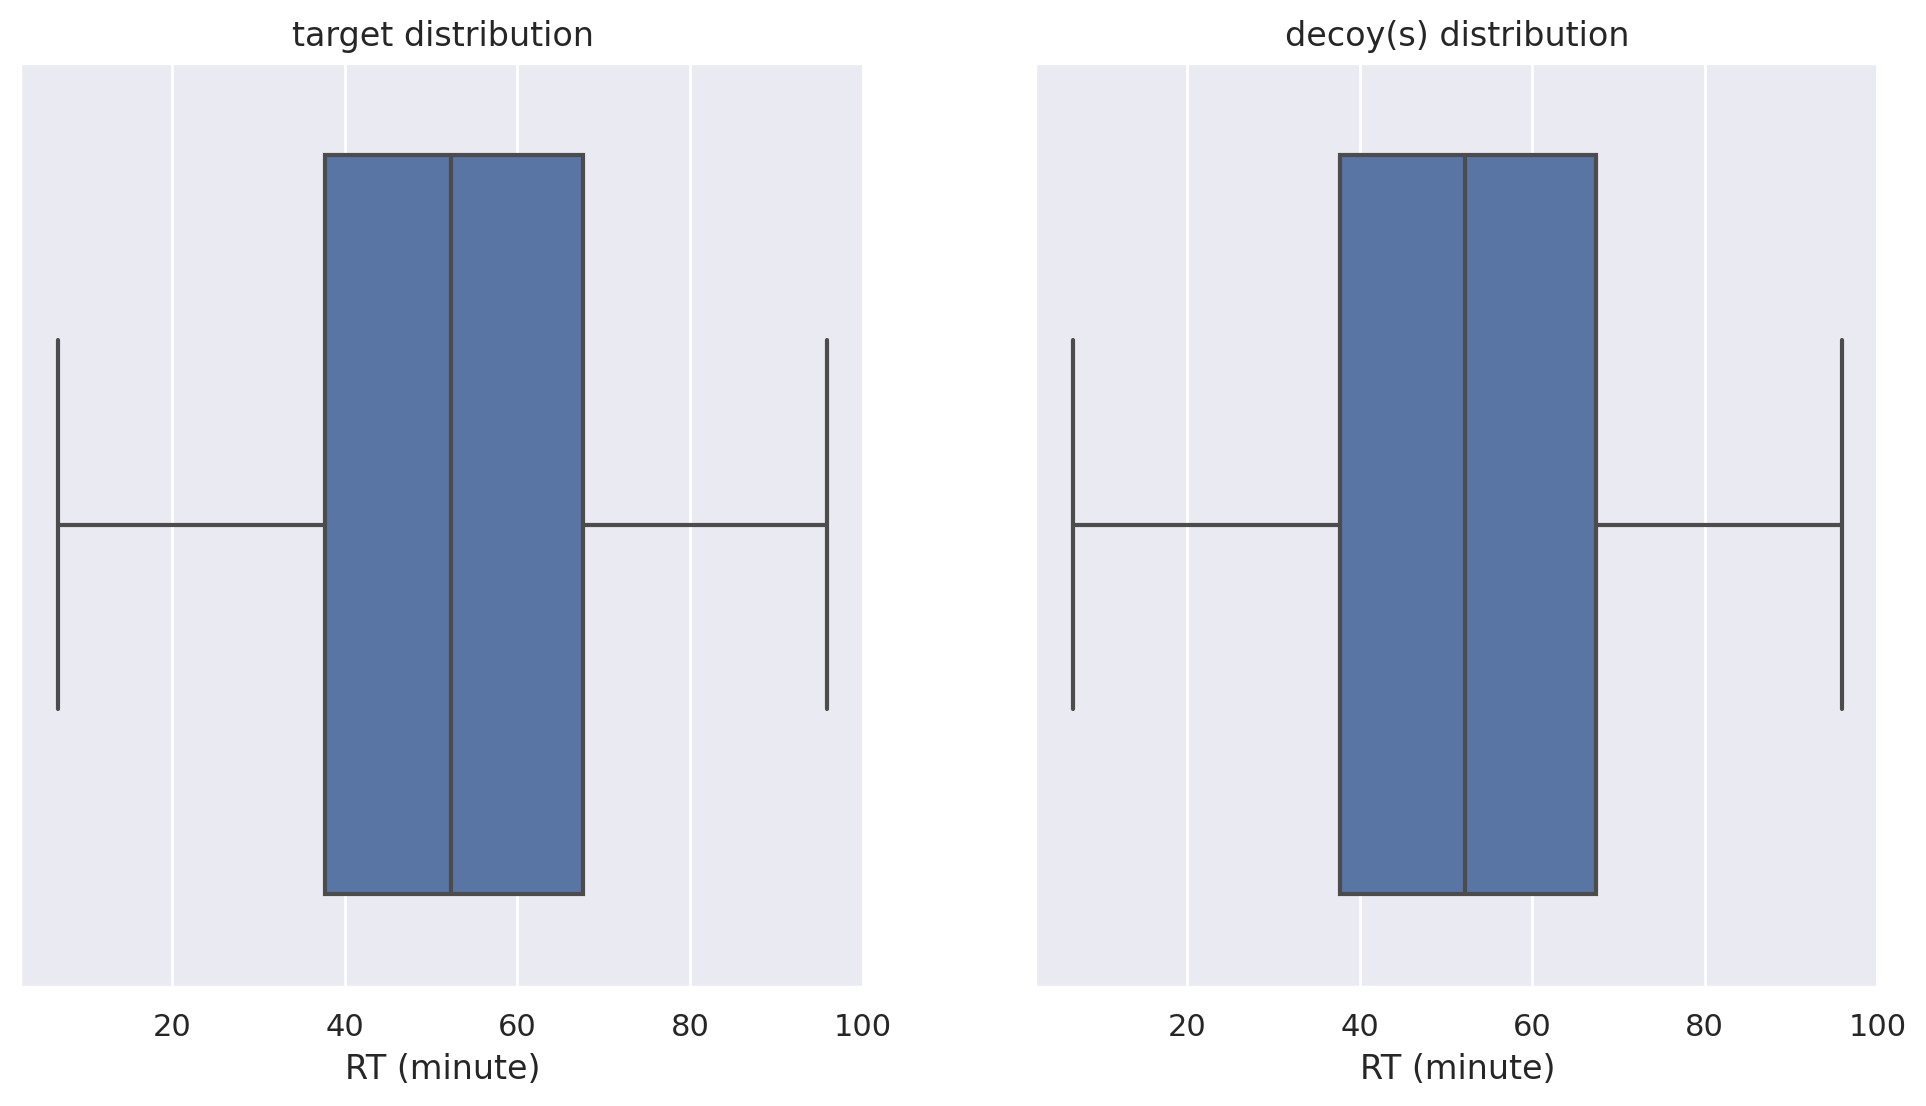

In [30]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.subplots(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=pred_target_data['y'])
plt.xlabel('RT (minute)')
plt.title('target distribution')
plt.subplot(1, 2, 2)
sns.boxplot(x=pred_decoy_data['y'])
plt.title('decoy(s) distribution')
plt.xlabel('RT (minute)')
plt.show()

**And try QQ plot**

In [31]:
df_pct = pd.DataFrame()
df_pct['q_target'] = np.percentile(pred_target_data['y'], range(100))
df_pct['q_decoy(s)'] = np.percentile(pred_decoy_data['y'], range(100))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


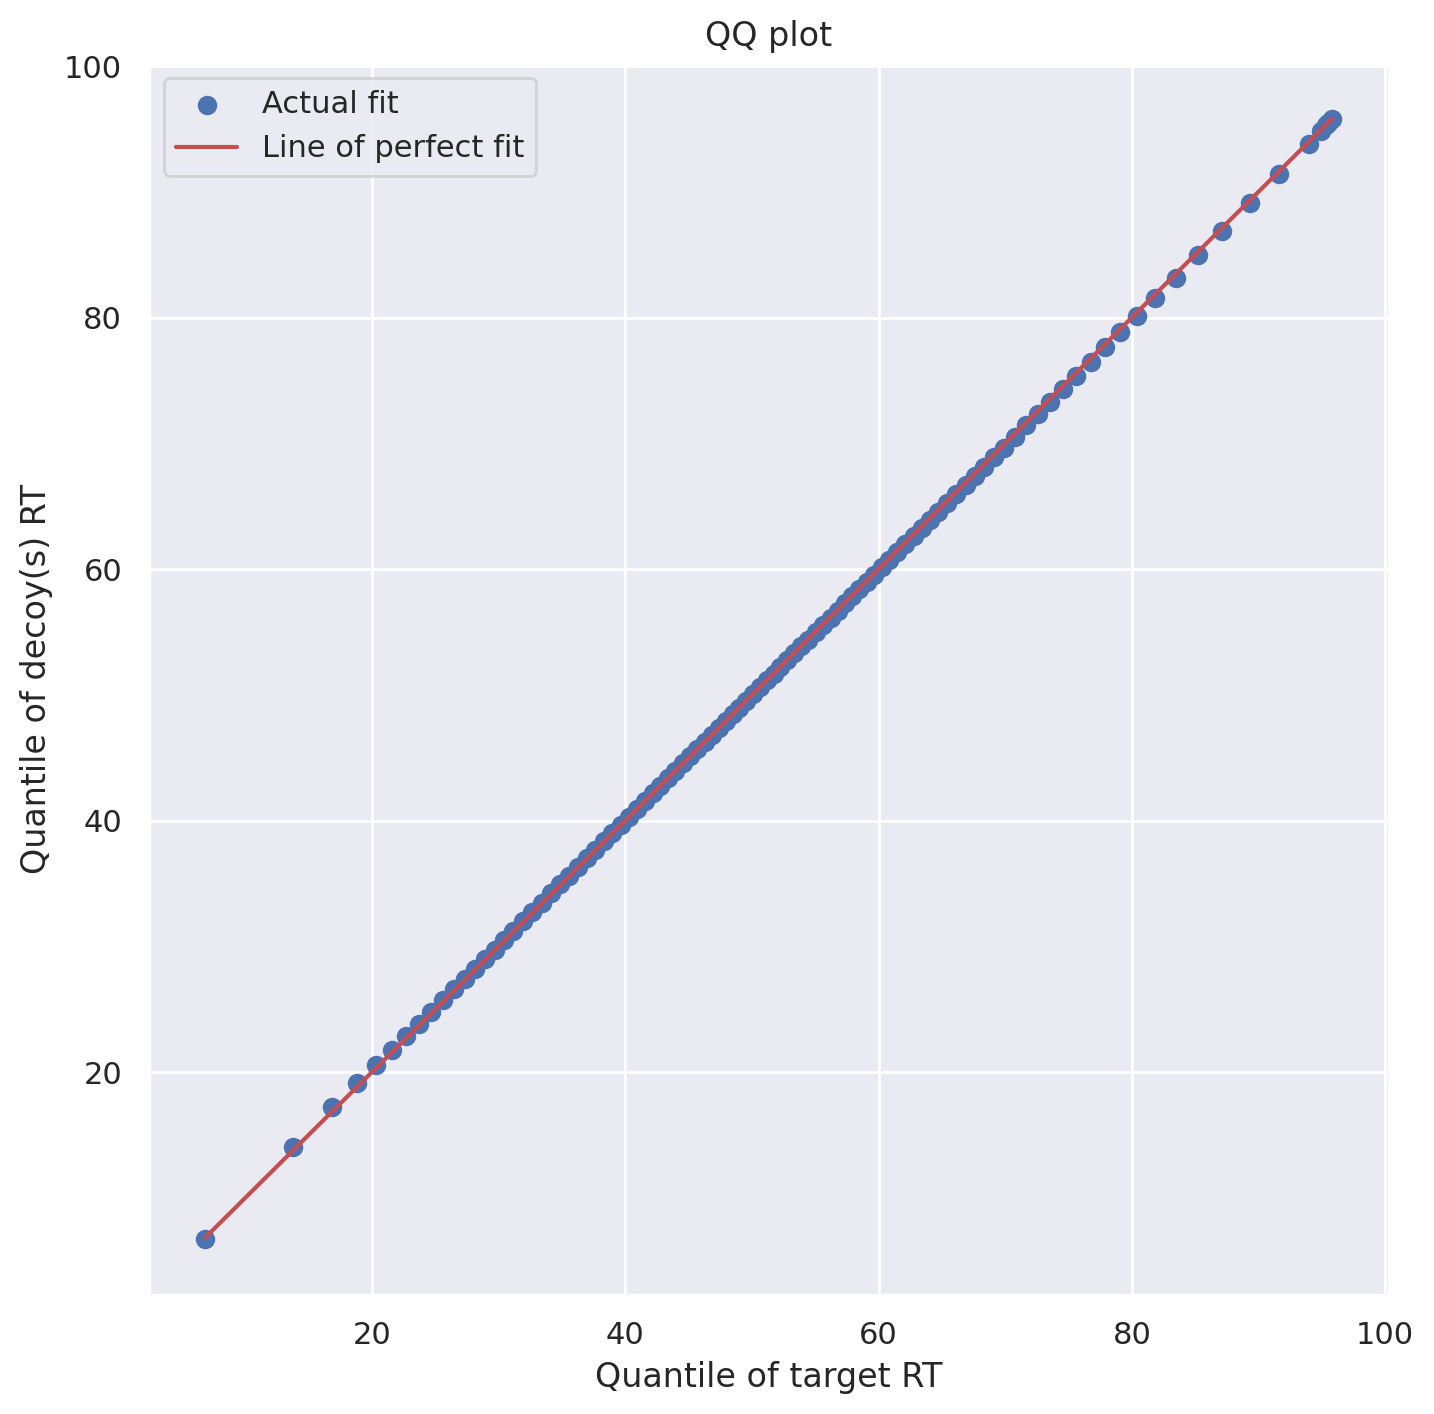

In [32]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_target', y='q_decoy(s)', data=df_pct, label='Actual fit');
sns.lineplot(x='q_target', y='q_target', data=df_pct, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of target RT')
plt.ylabel('Quantile of decoy(s) RT')
plt.legend()
plt.title("QQ plot");

**And look at it`s mini_batch**

In [33]:
target_qq_mini = pred_target_data['y'][10000:20000]
decoy_qq_mini = pred_decoy_data['y'][10000:20000]

In [34]:
df_pct_mini = pd.DataFrame()
df_pct_mini['q_target'] = np.percentile(target_qq_mini, range(100))
df_pct_mini['q_decoy(s)'] = np.percentile(decoy_qq_mini, range(100))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


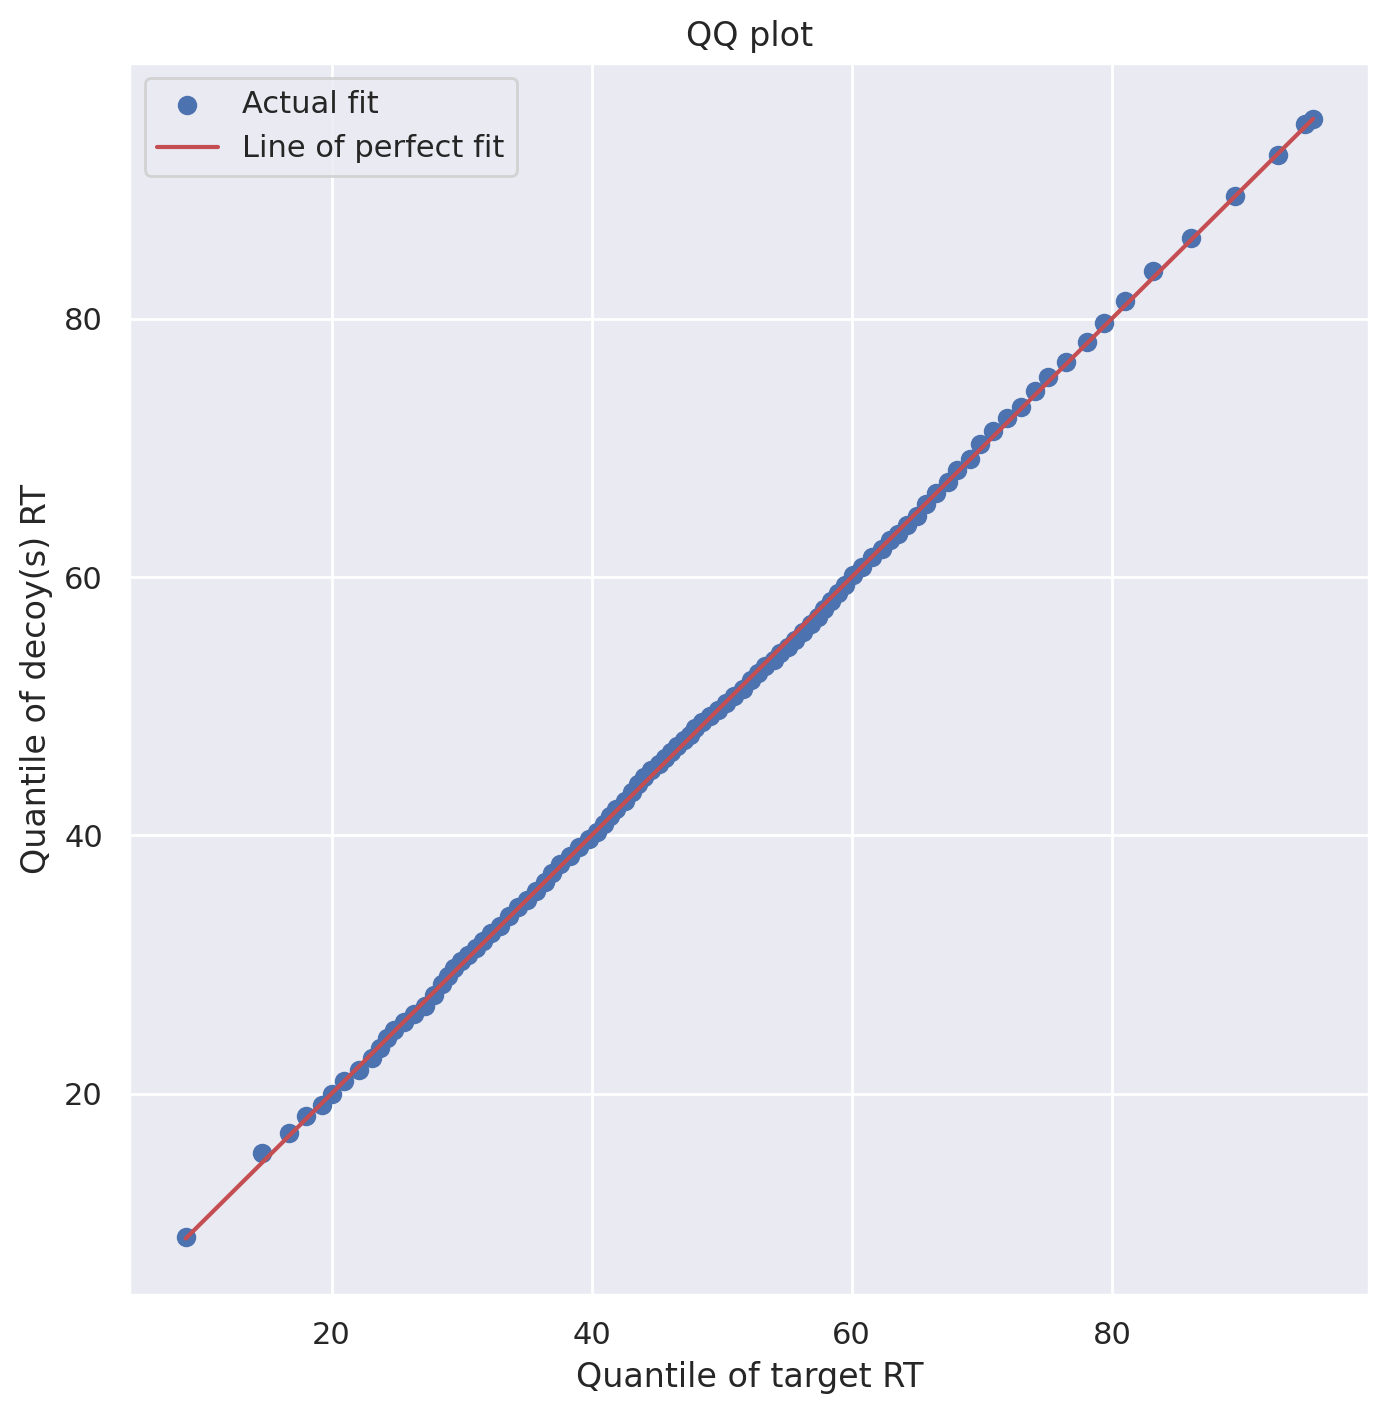

In [35]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_target', y='q_decoy(s)', data=df_pct_mini, label='Actual fit');
sns.lineplot(x='q_target', y='q_target', data=df_pct_mini, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of target RT')
plt.ylabel('Quantile of decoy(s) RT')
plt.legend()
plt.title("QQ plot");

**One more plot to analyze - roc curve**

In [36]:
def plot_auc(dstr1, dstr2):
    # Creating class labels for two distributions (0 - distribution1, 1 - distribution2)
    labels = np.concatenate([np.zeros(len(dstr1)), np.ones(len(dstr2))])

    # We construct the ROC curve and calculate its AUC
    fpr, tpr, _ = metrics.roc_curve(labels, np.concatenate([dstr1, dstr2]))
    roc_auc = metrics.auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [37]:
target_distribution = pred_target_data['y']
decoy_distribution = pred_decoy_data['y']

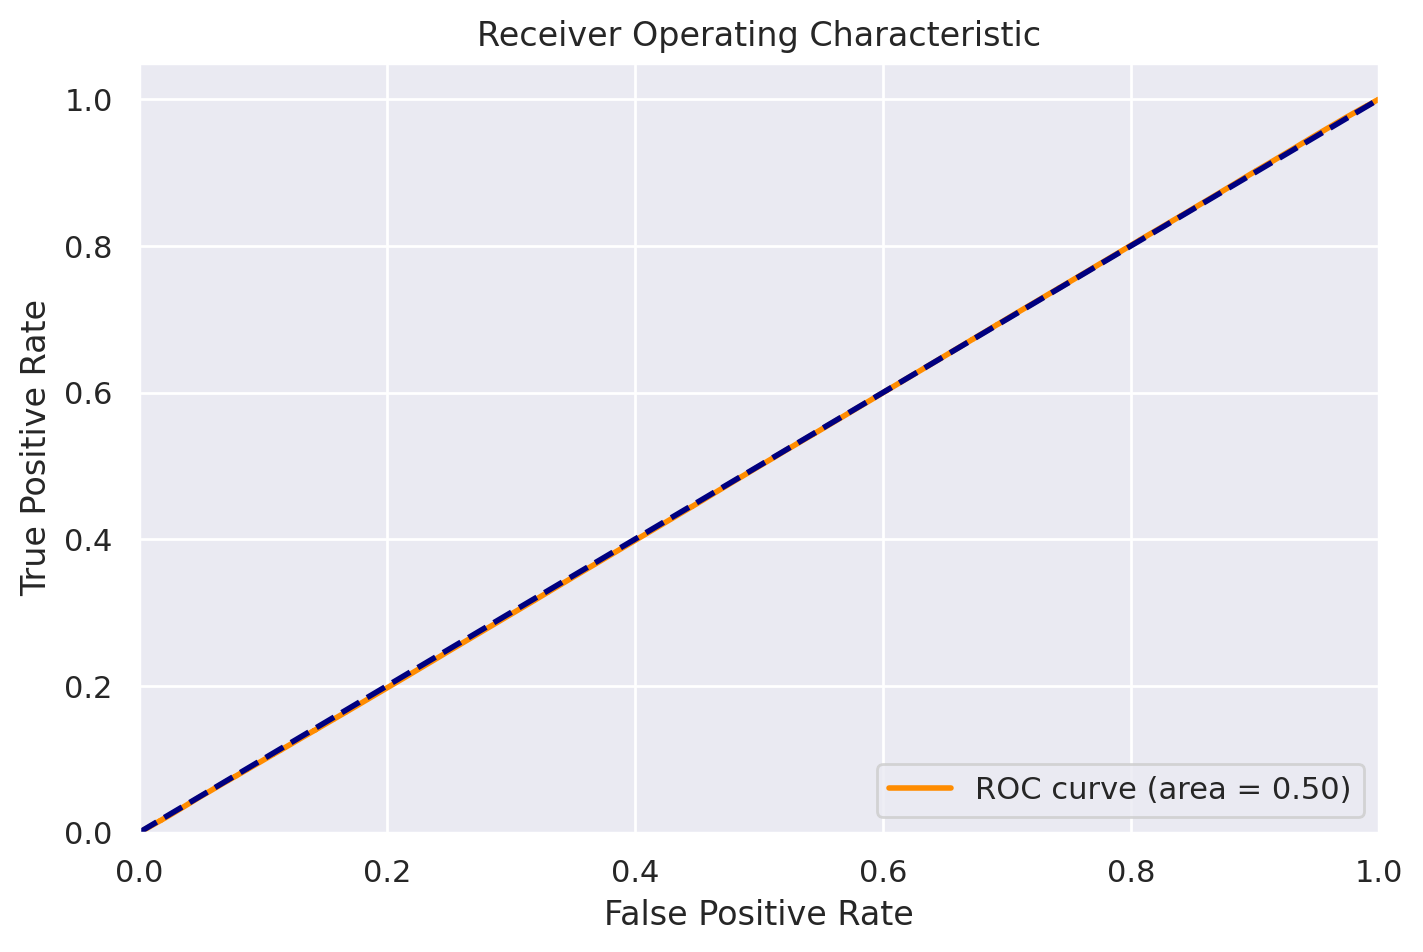

In [38]:
plot_auc(target_distribution, decoy_distribution)

Looking at mini_batch

In [39]:
target_distribution_mini = pred_target_data['y'][10000:20000]
decoy_distribution_mini = pred_decoy_data['y'][10000:20000]

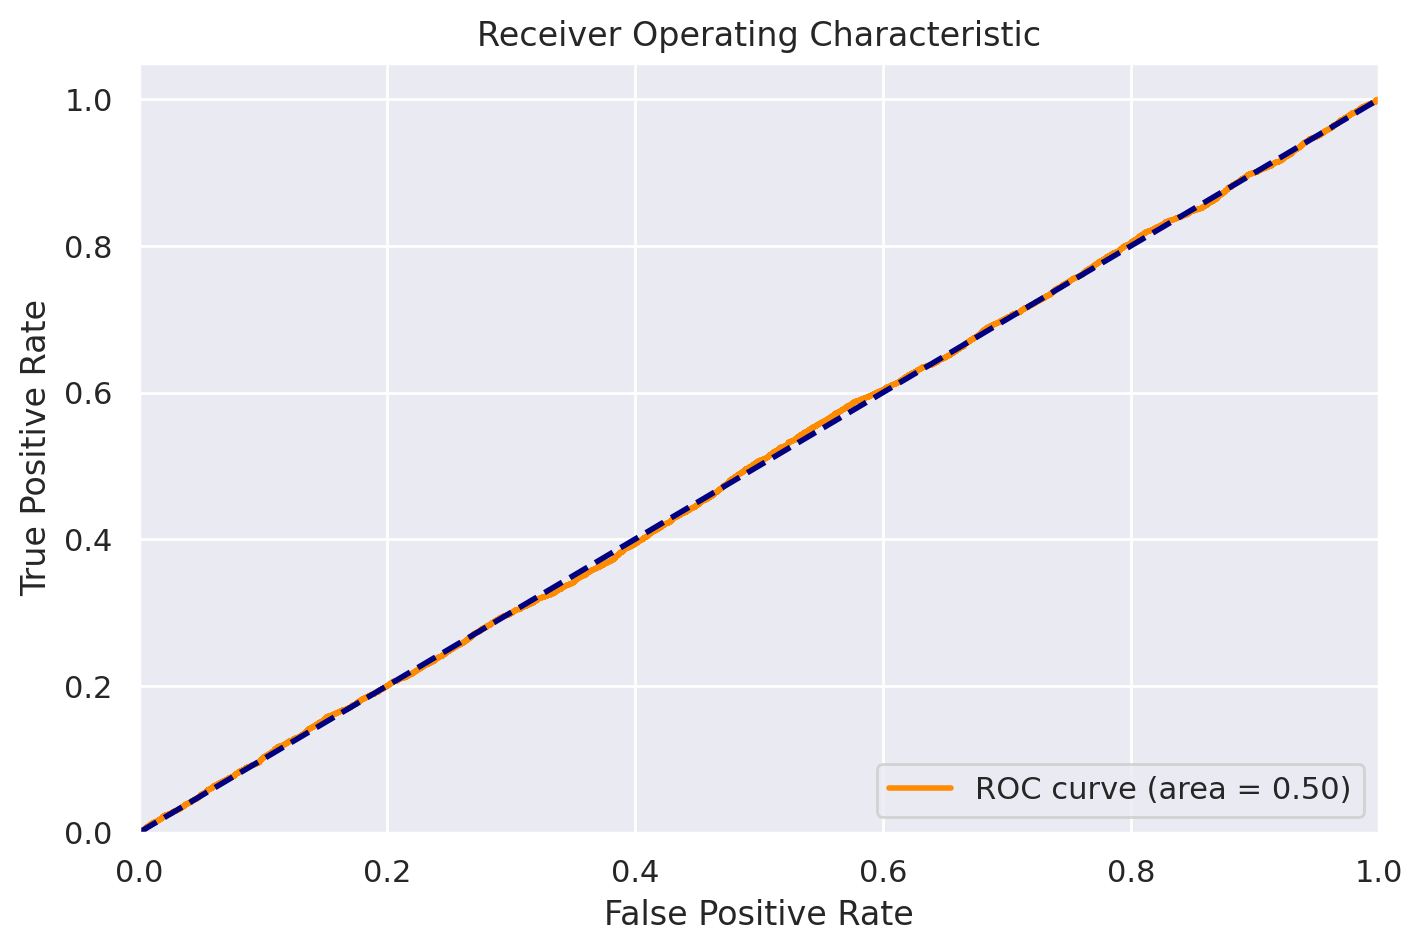

In [40]:
plot_auc(target_distribution_mini, decoy_distribution_mini)

### The next experiment is shuffle

In [41]:
def shuffle_string(s):
    if isinstance(s, str):
        s_list = list(s)
        middle_part = s_list[1:-1]
        random.shuffle(middle_part)
        s_list[1:-1] = middle_part
        return ''.join(s_list)
    else:
        return s

**Constracting DataFrame**

In [42]:
df_shuffled_decoys = decoy_df['x'].apply(shuffle_string).to_frame()

df_shuffled_decoys.to_csv('shuffled_decoys_to_predict_RT.tsv', index=None)

**Prediction part**

In [43]:
! python ../autort.py predict -t shuffled_decoys_to_predict_RT.tsv -s tf_model/model.json -o tf_prediction_shuffled_decoys/ -p test

2024-05-10 20:23:51.051933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 20:23:51.051991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 20:23:51.053531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Average ...
Load aa coding data from file tf_model/aa.tsv
AA types: 25
Longest peptide in input data: 42

['1', '2', '3', '4', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

Deep learning model: 0
1902/1902 [==============================] - 37s 19ms/step

Deep learning model: 1
1902/1902 [===============

In [44]:
! ls -l tf_prediction_shuffled_decoys/

total 195604
-rw-r--r-- 1 root root 137972167 May 10 21:53 test.tsv
-rw-r--r-- 1 root root  15578940 May 10 20:26 test_0.npy
-rw-r--r-- 1 root root  15578940 May 10 20:27 test_1.npy
-rw-r--r-- 1 root root  15578940 May 10 20:28 test_2.npy
-rw-r--r-- 1 root root  15578940 May 10 20:29 test_6.npy


**Converting to .tsv**

In [45]:
pred_shuffled_decoy_data = pd.read_csv("tf_prediction_shuffled_decoys/test.tsv",sep="\t")
pred_shuffled_decoy_data = pred_shuffled_decoy_data.rename(columns={'y_pred': 'y'})
pred_shuffled_decoy_data.head()

,x,y
0,TL2VVCSNEDE3NLYWSQAYR,53.979633
1,TN3ESLD4SVYANESWVLCQR,55.580530
2,TLNSYYLQEDSC3VWAENV2R,55.061676
3,3STCLEQSWVYVEN2ALNDYR,67.054825
4,3ECEATNDQNLLSVVY4SWSR,68.431680


In [46]:
r2 = r2_score(pred_target_data['y'], pred_shuffled_decoy_data['y'])

print(f"R2 score: {r2}")

R2 score: 0.8613864130985583


In [47]:
diff = abs(pred_target_data['y'] - pred_shuffled_decoy_data['y'])
print(f"Max difference between target and decoy: {max(diff)};\n Min diff: {min(diff)}")

Max difference between target and decoy: 51.42972700000001;
 Min diff: 0.0


**Drawing plots**

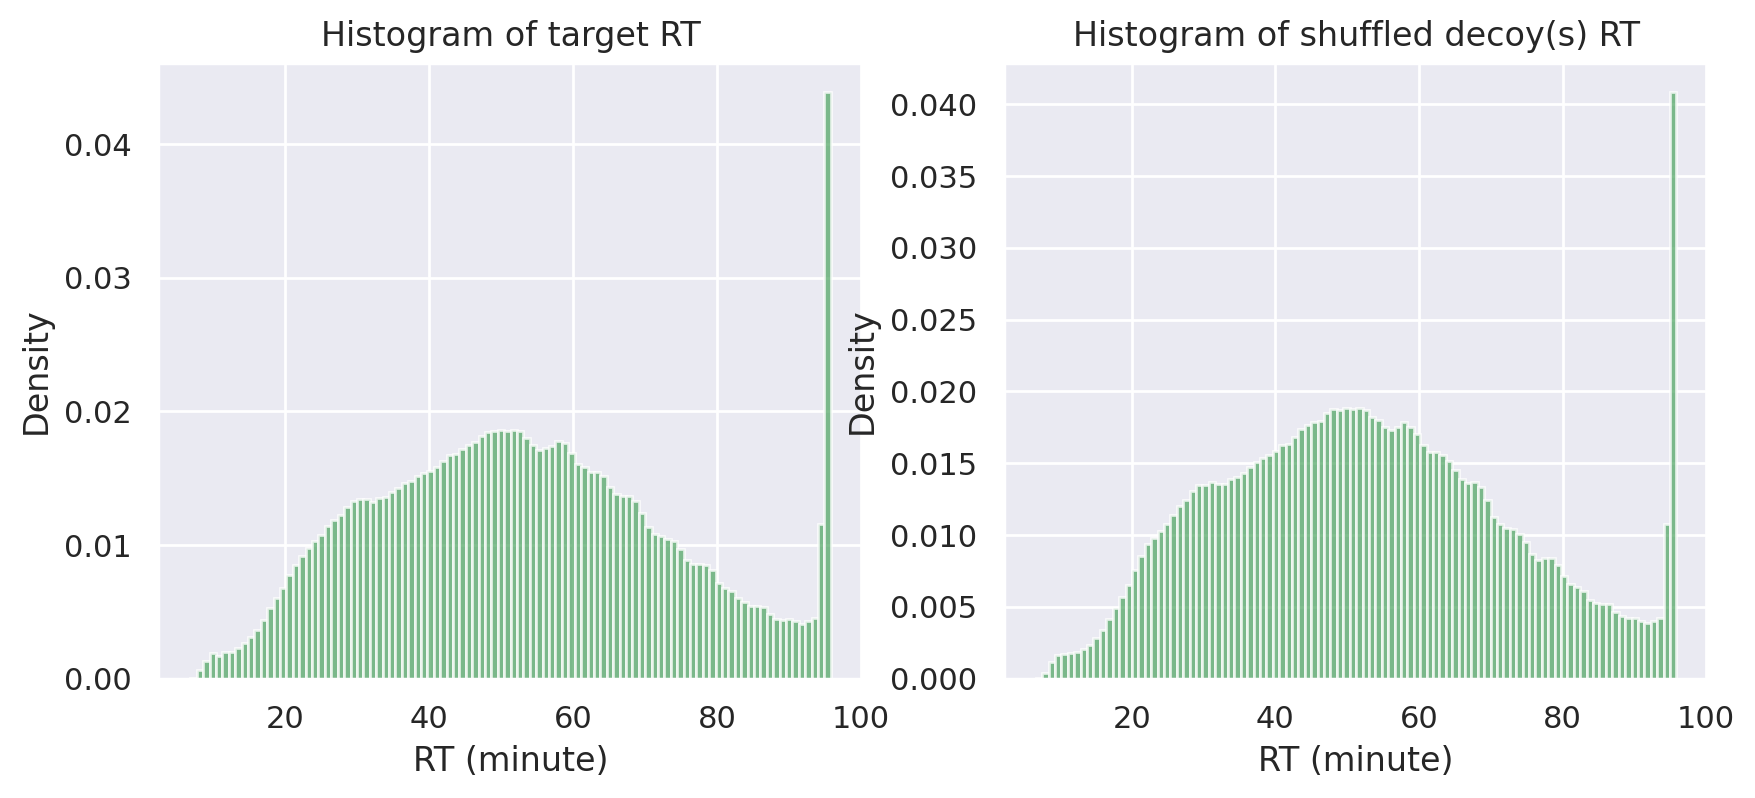

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(pred_target_data['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[0].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of target RT')
axes[1].hist(pred_shuffled_decoy_data['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[1].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of shuffled decoy(s) RT')
plt.grid(True)
plt.show()

histograms with percentile <= 85

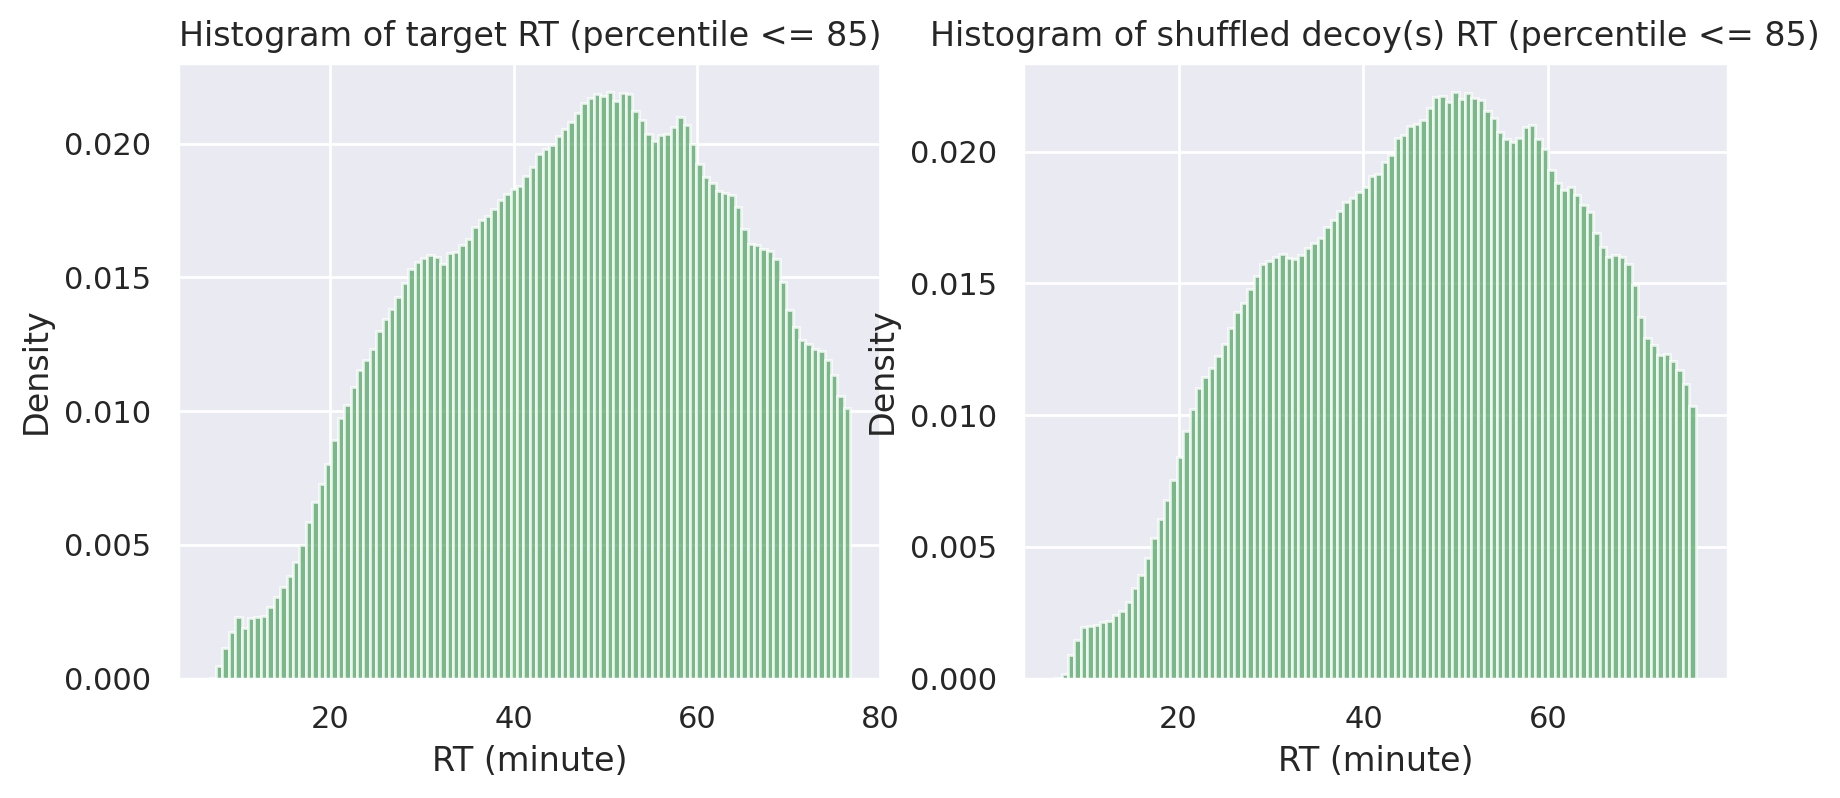

In [49]:
boolean_value1 = pred_target_data['y'].to_numpy() <= np.percentile(pred_target_data['y'].to_numpy(), 85)
boolean_value2 = pred_shuffled_decoy_data['y'].to_numpy() <= np.percentile(pred_shuffled_decoy_data['y'].to_numpy(), 85)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(pred_target_data[boolean_value1]['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[0].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of target RT (percentile <= 85)')
axes[1].hist(pred_shuffled_decoy_data[boolean_value2]['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[1].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of shuffled decoy(s) RT (percentile <= 85)')
plt.grid(True)
plt.show()

**boxplots**

/tmp/ipykernel_25/4206609724.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


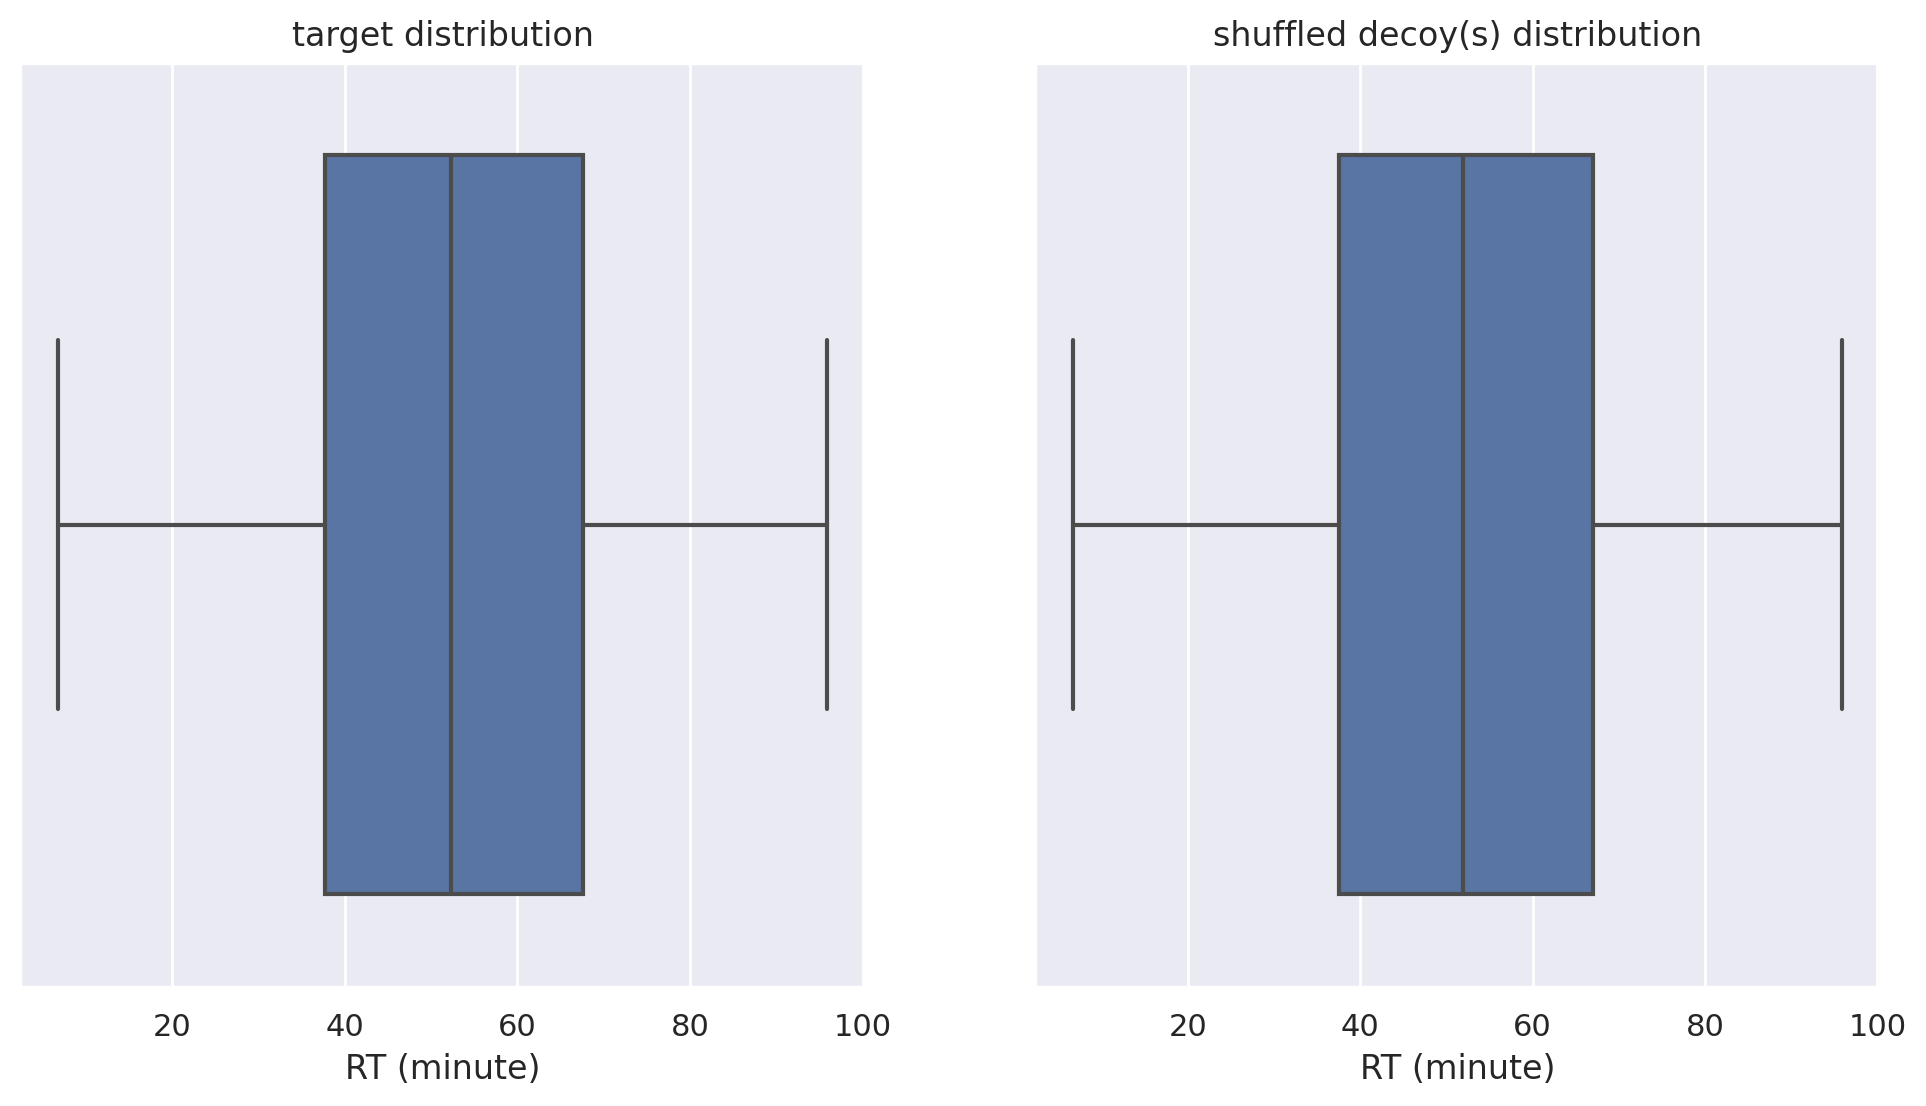

In [50]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.subplots(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=pred_target_data['y'])
plt.xlabel('RT (minute)')
plt.title('target distribution')
plt.subplot(1, 2, 2)
sns.boxplot(x=pred_shuffled_decoy_data['y'])
plt.title('shuffled decoy(s) distribution')
plt.xlabel('RT (minute)')
plt.show()

**QQ plot**

In [51]:
df_pct_shuffled = pd.DataFrame()
df_pct_shuffled['q_target'] = np.percentile(pred_target_data['y'], range(100))
df_pct_shuffled['q_shuffled_decoy(s)'] = np.percentile(pred_shuffled_decoy_data['y'], range(100))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


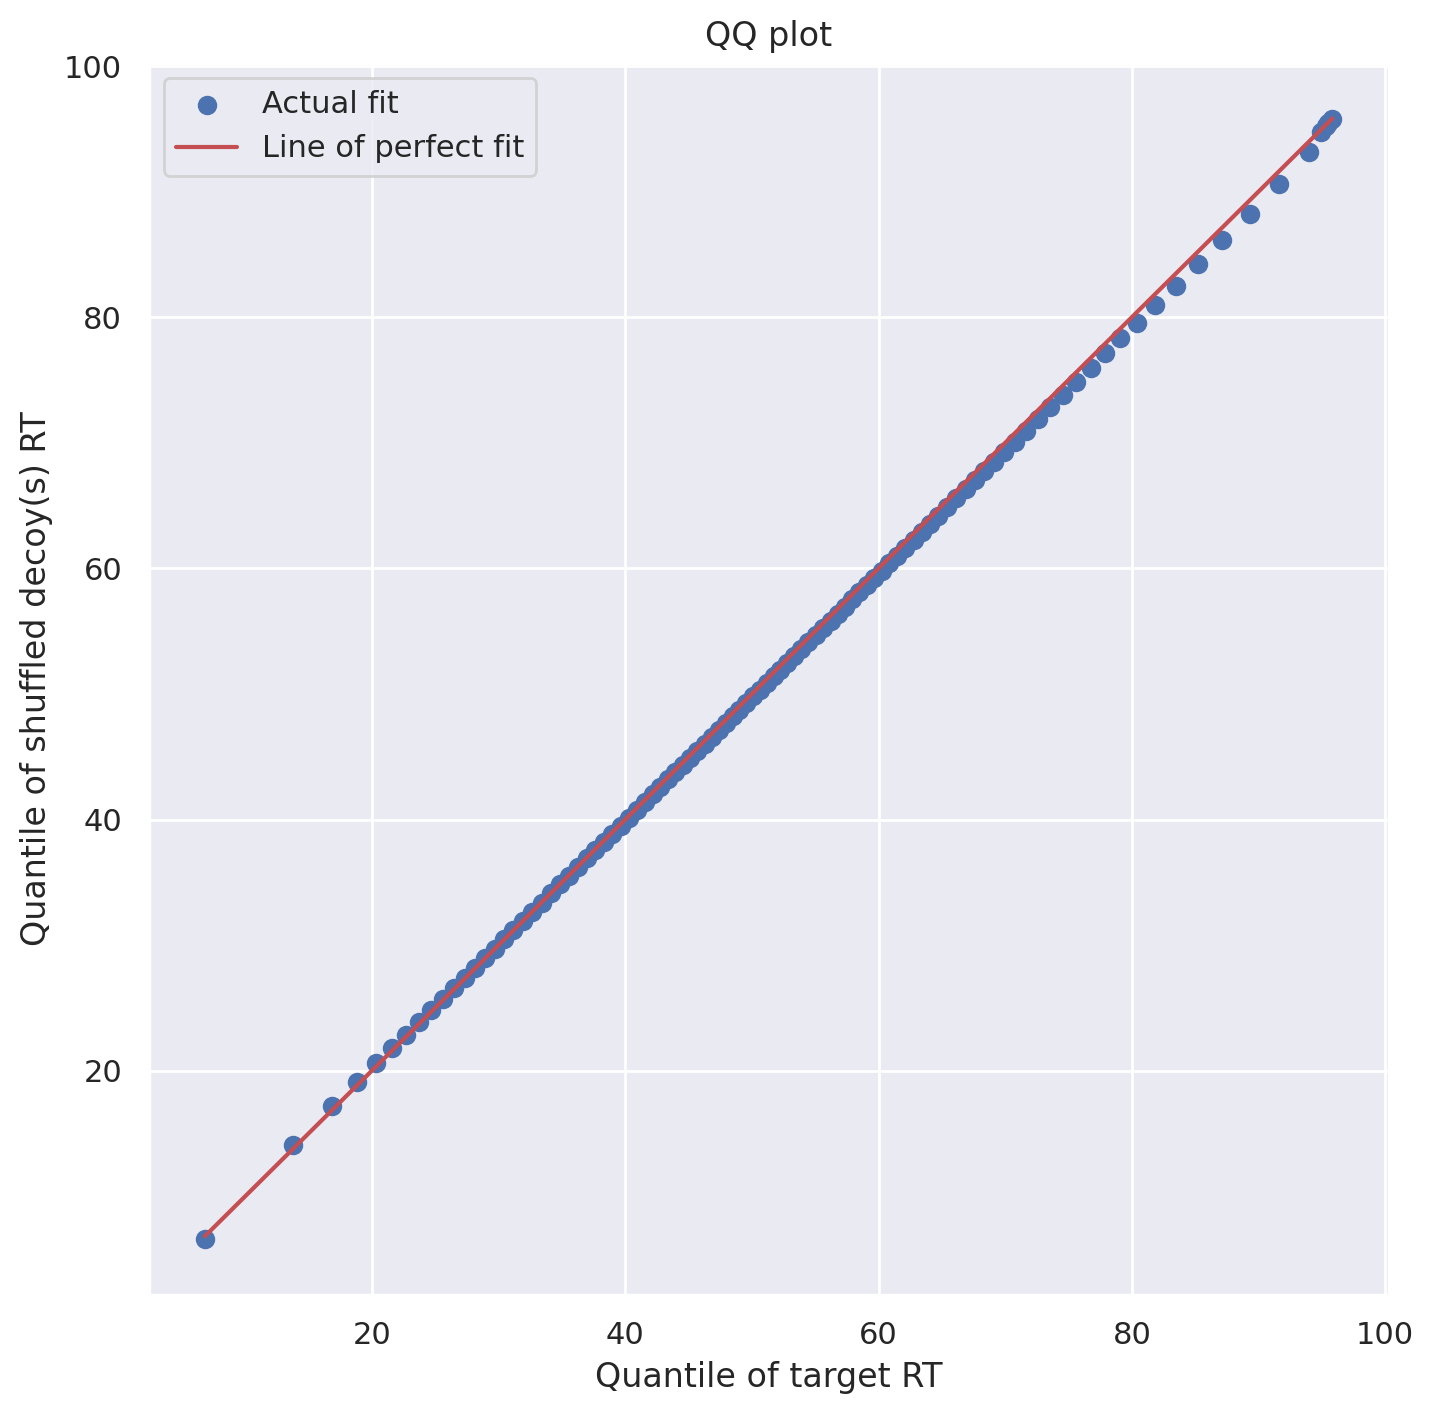

In [52]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_target', y='q_shuffled_decoy(s)', data=df_pct_shuffled, label='Actual fit');
sns.lineplot(x='q_target', y='q_target', data=df_pct_shuffled, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of target RT')
plt.ylabel('Quantile of shuffled decoy(s) RT')
plt.legend()
plt.title("QQ plot");

It`s mini_batch

In [53]:
df_pct_shuffled_mini = pd.DataFrame()
df_pct_shuffled_mini['q_target'] = np.percentile(pred_target_data['y'][10000:20000], range(100))
df_pct_shuffled_mini['q_shuffled_decoy(s)'] = np.percentile(pred_shuffled_decoy_data['y'][10000:20000], range(100))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


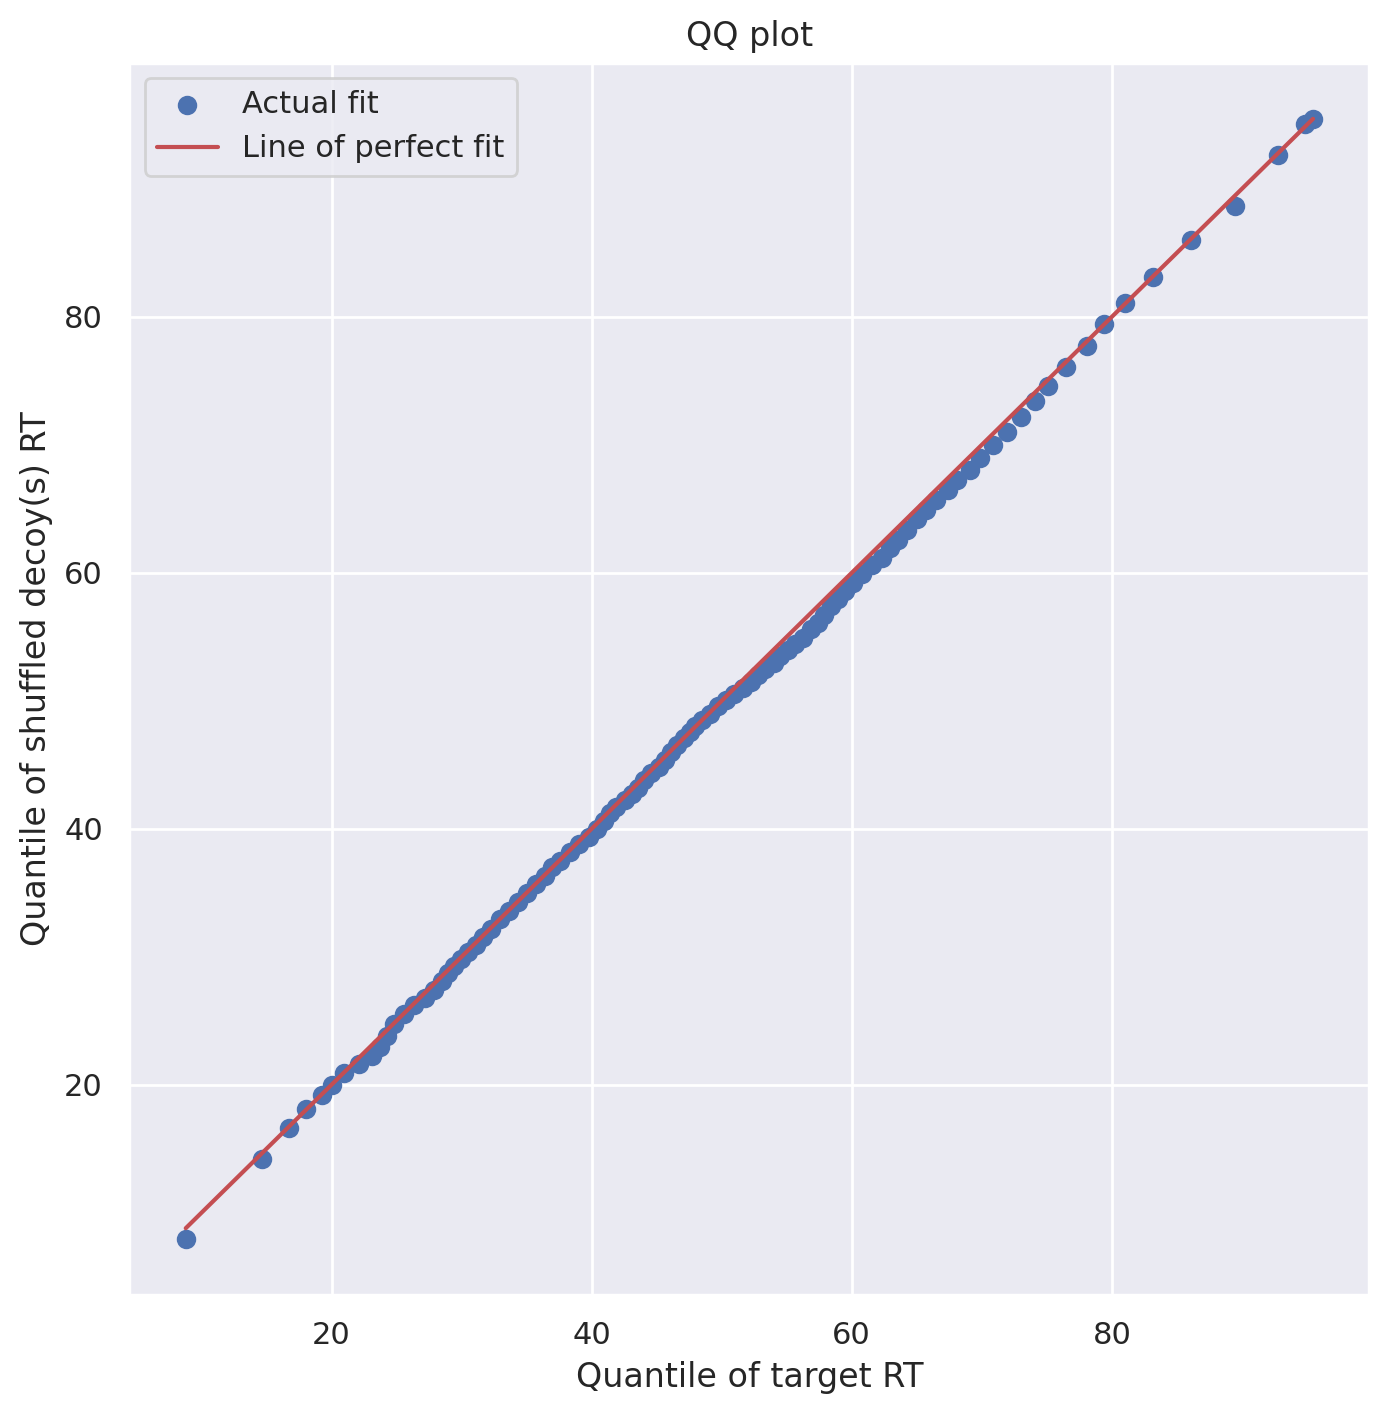

In [54]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_target', y='q_shuffled_decoy(s)', data=df_pct_shuffled_mini, label='Actual fit');
sns.lineplot(x='q_target', y='q_target', data=df_pct_shuffled_mini, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of target RT')
plt.ylabel('Quantile of shuffled decoy(s) RT')
plt.legend()
plt.title("QQ plot");

**AUC-ROC**

In [55]:
distribution_shuffled = pred_shuffled_decoy_data['y']

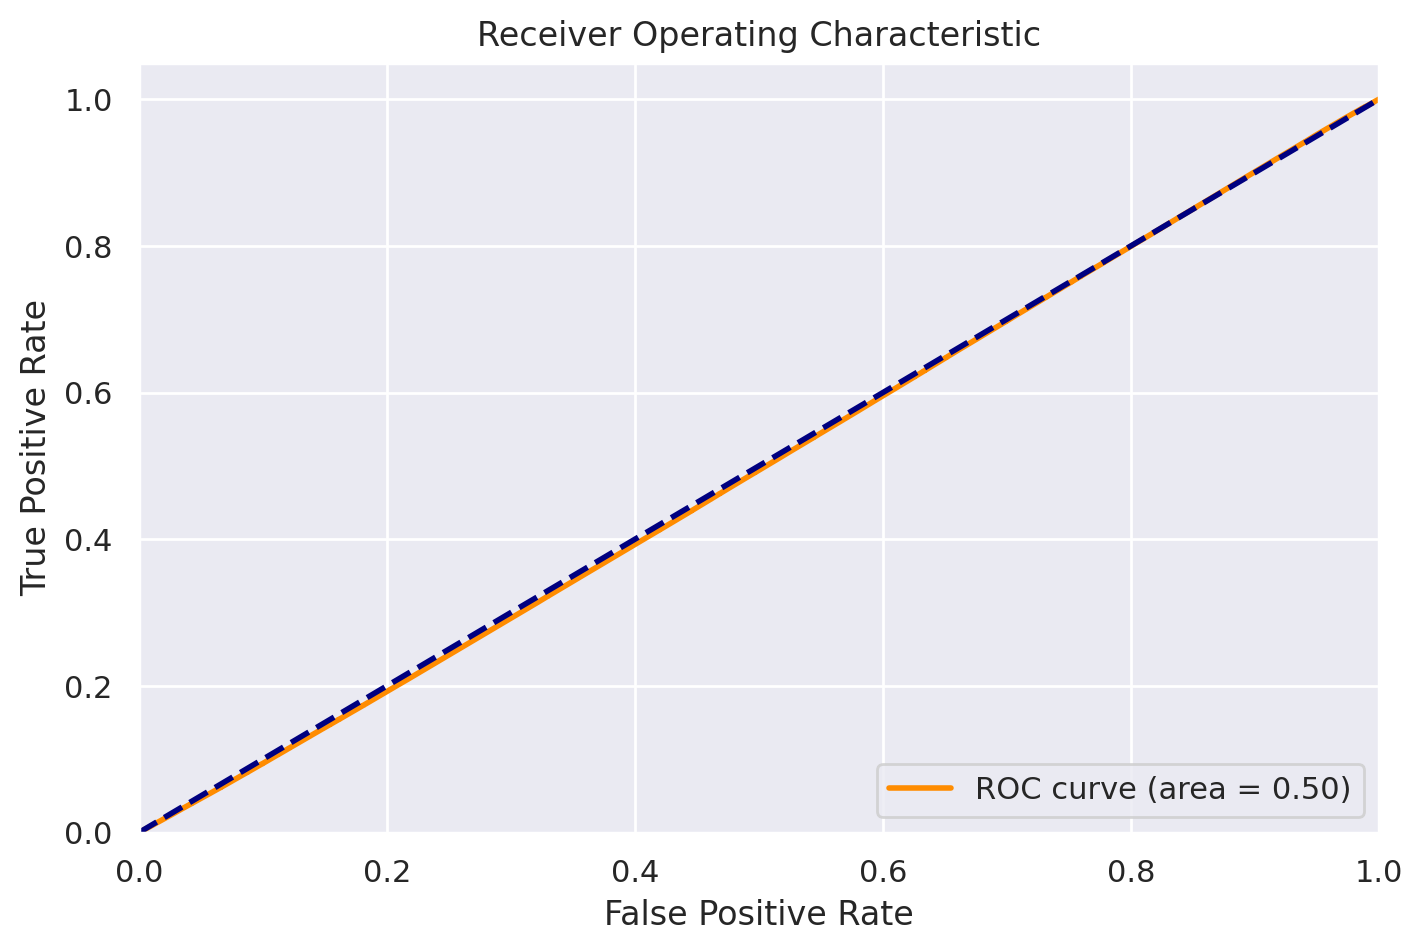

In [56]:
plot_auc(target_distribution, distribution_shuffled)

It`s mini_batch

In [57]:
distribution_shuffled_mini = pred_shuffled_decoy_data['y'][10000:20000]

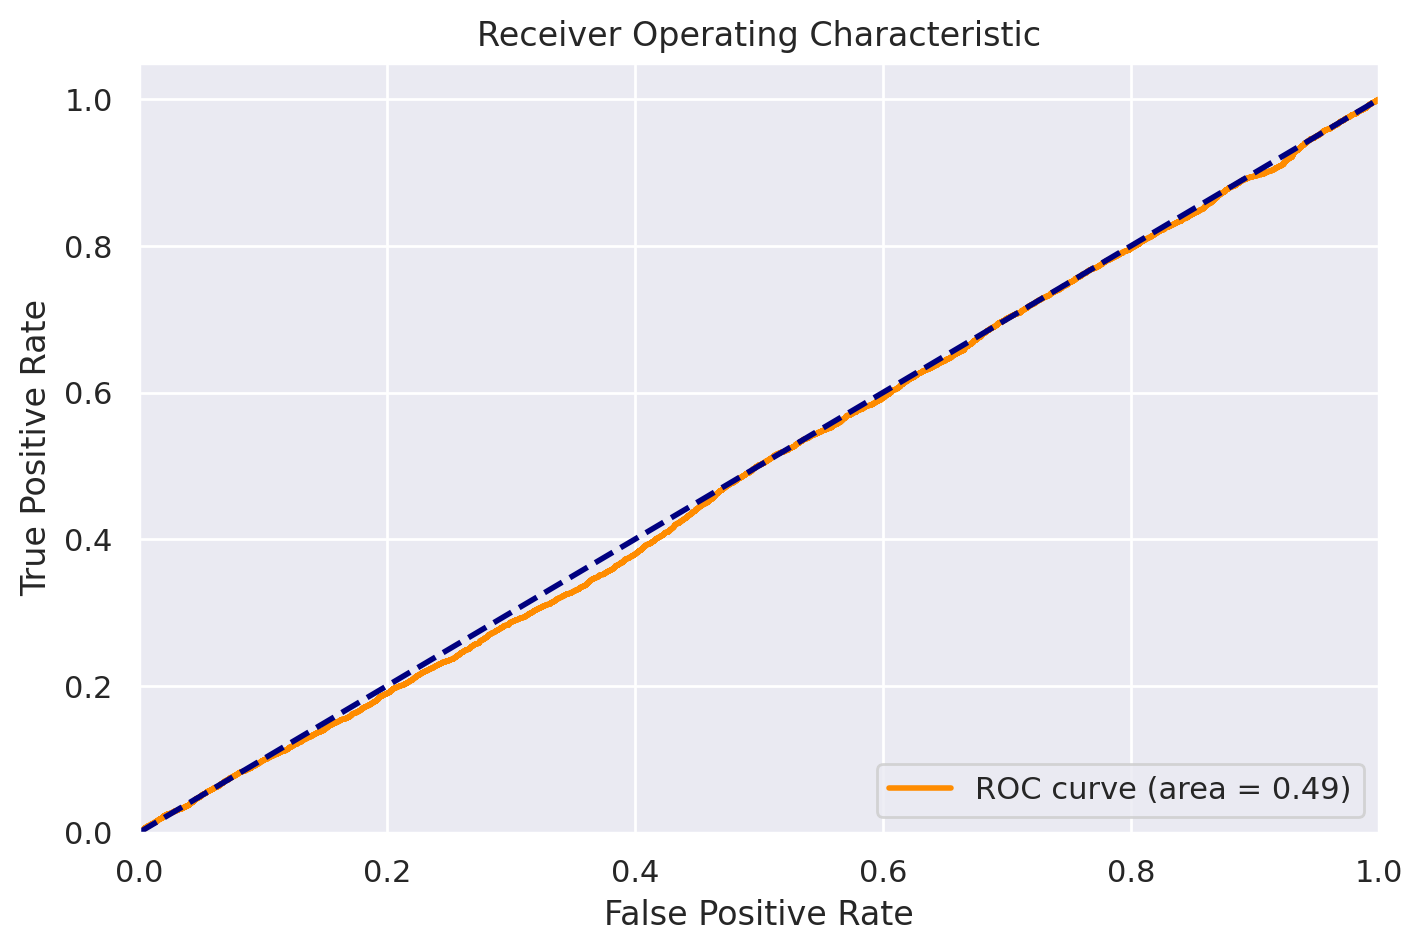

In [58]:
plot_auc(target_distribution_mini, distribution_shuffled_mini)